<a name="top"></a>
<div style="width:1000 px">
 
<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>
<div style="float:left; width:98 px; height:100px;">
<img src="http://seasonedchaos.github.io/assets/img/SC_logo.jpg" alt="Seasoned Chaos logo" style="height: 98px;">
</div>
  
<h1 style="margin-left: 120px;"> Download and Plot a Seasonal Forecast from Copernicus Climate Data Store </h1>
 
<p style="margin-left: 120px;">   By: Kayla Besong, Seasoned Chaos team </p>
<p style="margin-left: 120px;">   This code leverages the CDS to grab and plot seasonal forecast anomalies on pressure levels. The CDS API client is provided as a function where the inputs are the selections made on the CDS webpage and files are stored locally after requested. It is important that the inputs match exactly what the client is looking for or it will fail. You will also have to sign in to the CDS immediately after requesting for the first time. For more information please go <a href= https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-postprocessed-pressure-levels?tab=form> here </a> . Multple models are selected at once with the DJF 500mb geopotential height and 850mb temperature anomaliey ultimately plotted for 6 models. The plotting code is adaptive and will adjust panels according to the number of models selected. </p>
 
<div style="clear:both"></div>
</div>
 
<hr style="height:2px;">

## NOTE:

This is not a code for beginners and may require some debugging with package dependencies and complications with the CDS API. 

The package dependencies for this program are a bit tricky and we are still working on making a more user friendly version. In the meantime, we have provided a .txt file with all the packages found in the python environment this script was developed in. Downland the requirements.txt file in the repo, create a new python env and then run pip install -r requirements.txt.

Further, this may not work on MacOS due to multiprocess. You can still download data from CDS though, just remove the multiprocessing component. 

Nonetheless there are many epic code tidbits in here for you to steal and do with as you wish. Python is open source afterall.....

In [2]:

import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import cdsapi
from contextlib import closing
import multiprocess as mp


import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
import calendar


In [14]:
def cs3_grabber(originating_centre, system, variable, pressure_level, product_type, init_year, init_mon, leadtime_month_list):
    
    
    ''' This function is an adapted version of the Copernicus Climate Data Store (CDS) API client to download seasonal forecasts on pressure levels. After making all of your selections on their site,
        they give you a code to copy, paste, and run to download data. This is that, but with all the variables and information here. To most accurately feed this function it is encouraged you visit 
        https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-postprocessed-pressure-levels?tab=form and select the model, pressure levels, and variable combinations actually available. 
        This function saves the file locally to your working directory. 
    
    
    Input Variables:

        originating_centre: (string) The available modeling centers providing forecasts: 'ncep', 'ecmwf', 'ukmo', 'cmcc', 'meteo_france', 'jma', 'dwd', 'eccc' 

        system: (string) The corresponding, specific 'version' of the model from provider selected above in consecutive order (as of Dec 2022): '2', '5', '600', '35', '8', '2', '21', '2' or '3'}

        variable: (string or list of strings) Variables available: 'geopotential_anomaly', 'specific_humidity_anomaly', 'temperature_anomaly', 'u_component_of_wind_anomaly', 'v_component_of_wind_anomaly'        

        pressure_level: (string or list of strings) Note that not all pressure levels are available for all variable/model combinations (mostly at lower levels) and incorrect selection can lead to error.
                                                    ['10', '30', '50','100', '200', '300', '400', '500', '700', '850', '925', '1000'] 
        
        product_type: (string or list of strings) The 'ensemble_mean' or 'monthly_mean'.
        
        init_year: (string or list of strings) The numerical year value for initialization. Caution for splitting the end and beginning of the year! 
        
        init_mon: (string or list of strings)  The numerical month value for initialization. Selecting '12', for example, means the forecast begins December 1st. 
        
        leadtime_month_list: (string or list of strings) The numerical month value such as ['1', '2', '3'] from the initalization month. So if you select init_mon as '1' and do a lead month of '2' your output would be for February
    
    Output:
        
        A netcdf file saved to working directory, no stored variable. 
    
    '''


    c = cdsapi.Client()

    c.retrieve(
        'seasonal-postprocessed-pressure-levels',
        {
            'format': 'netcdf',
            'originating_centre': originating_centre,
            'system': system,
            'variable': variable,
            'pressure_level': pressure_level,
            'product_type': product_type,
            'year': init_year,
            'month': init_mon,
            'leadtime_month': leadtime_month_list,
        },
        f'CS3_{originating_centre}_{init_year}_{init_mon}.nc')
    
    print(originating_centre, 'has finished') 

# Tuning inputs

See https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-postprocessed-pressure-levels?tab=form for more on how to correctly input all of the parameters.
Incorrect input will immediately lead to error.
Another immediate error related to 'signing in' to the Copernicus CDS may pop up. If you click the link and sign in, then it should be fine.  

### Model Selection

In [4]:
# creating a dictionary of the interested models and their corresponding current 'versions' or systems
# note the keys of this dictionary are used multiple times throughout the rest of the code

model_dict = {'ncep': '2', 'ecmwf': '5', 'ukmo': '600' }#, 'cmcc': '35', 'meteo_france': '8', 'jma': '2'}

### Variable Selection and Inititalization 

In [5]:
variable_list = ['geopotential_anomaly', 'temperature_anomaly']
pressure_level = ['500', '850']
product_type = 'ensemble_mean'
init_year = '2021'
init_mon = '12'
lead_time_mons = ['1', '2', '3']

# Multiprocessing the Request

## Make sure you have the CDS API installed first

You can follow the directions here: https://cds.climate.copernicus.eu/api-how-to

You will have to ensure you have an account with them and that your API key + user ID is filled in your cdsapirc file.

## This may take a moment

This uses mulitprocessing Pool to send out a request for each model at the same time, rather than waiting one after another. This may still take a moment as the requests are external and thus you are waiting for CDS to serve your request. Don't give up on it, but maybe run it while you're doing something else.

Note: while waiting you should see INFO Welcome to the CDS, if that is the case you just have to wait for their response. If not and you're getting errors or it just kind of stops, there is either an error in your input causing the request to be incorrect or package dependency issues.

## This may also not work on MacOS

Multiprocess and MacOS (at least on my device) are not agreeing. If you have a work around, let us know, but we are still debugging this! This code was run successfully on a remote research server. 

In [ ]:
# starmap function accepts a function and list of that function's arguments , map takes 1. 
# Here we loop through the keys of our dictionary to generate requests = to the number of models. There are only 8 max model choices. 
# If you end up recycling this code, such as using it for years or pressure levels, It is advised not to go beyond 8? Don't send 100. 

with closing(mp.Pool(len(model_dict))) as p:
    p.starmap(cs3_grabber, [(mod, model_dict[mod], variable_list, pressure_level, product_type, init_year, init_mon, lead_time_mons) for mod in model_dict.keys()])
    p.terminate()

# Read and Plot! 

## The rest of this code is designed for pressure and temperature anomalies. 

For temperature, the 850mb level was selected as not all models selected above have temperature anomaly below that level.


In [160]:
temp = []
z500 = []

for mod in model_dict.keys():
    
    file = xr.open_dataset(f'CS3_{mod}_{init_year}_{init_mon}.nc')
    
    temp.append(file.ta.sel(level = 850).mean('time'))
    z500.append(file.za.sel(level = 500).mean('time')/9.81) #convert to meters

### The plot is variable and adjusts to the number of models selected

If there are 4 or less models, only a row for pressure and temperature each. If there are more than 4, the row count doubles.

In [161]:
if len(model_dict.keys()) <= 4:
    ncols = len(model_dict.keys())
    nrows = 2
    fig_size = (30,10)              # figsize is pretty good for plots > 2 model selctions, might need editing for less than that
    
    slicer = len(model_dict.keys()) # the 'slicer' is worked out math for the plotting below so correct plots are turned on/off

else:
    
    ncols = 4
    nrows = 4
    fig_size = (30,20)
    slicer = 4


A fancy way to ensure your plot title matches whatever months are selected

In [162]:
mons = list(calendar.month_name)
int_init_mon = int(init_mon)
int_lead_mons = [(int(x)-1)+int_init_mon for x in lead_time_mons]

plot_string_arr = []

for m in int_lead_mons:
    if m > 12:
        m = m-12
        plot_string_arr.append(mons[m][0])
    else:
        plot_string_arr.append(mons[m][0])
        
plot_string = ''.join(plot_string_arr)      

Note: Lambert conformal centered on the US was used to show the mid to high latitudes as this was originally created to highlight the Pacific North American pattern. 

In [163]:
def formatter(ax, extent):
    
    ''' This function is designed to format cartopy subplots as the sliding amount of panels requires that not all panels be plotted and thus,
        not all panels be formatted. This eliminates redundancy. Other parameters hard coded here such as the xlabel font size could become inputs
        but it is just as easy to change them here.

    Input Variables:

        ax = (cartopy.mpl.geoaxes.GeoAxesSubplot) The subplot object.
        
        extent = (list of 4) Extent of the map in [west, east, south, north].
        
        
    Output:
    
        The input ax (cartopy.mpl.geoaxes.GeoAxesSubplot) object but formatted accordingly. '''
    
    
    ax.set_extent(extent, crs = lccproj)                                                                             # Set the extent according to above
    ax.add_feature(cf.STATES, linewidth=1.5, edgecolor='grey', alpha = 0.5)                                                       # Add state boundaries 
    ax.coastlines(zorder = 3, color='grey', linewidths = 1.5, alpha = 0.5)                                                        # Add coastlines
    gl = ax.gridlines(color = 'lightgrey', draw_labels=True, linewidths = 1.5, x_inline=False, y_inline=False)       # Add the gridlines and the lat/lon labels

    ## most of this code is formatting the gridlines and axis labels. Edit as you wish. 

    gl.ylocator = mticker.FixedLocator([0, 20, 40])
    gl.xlocator = mticker.FixedLocator(np.arange(-180,40, 40))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'rotation': 0}
    gl.ylabel_style = {'size': 15, 'rotation': 0}
    gl.right_labels = False
    gl.left_labels = False   
    gl.top_labels = False

    return ax

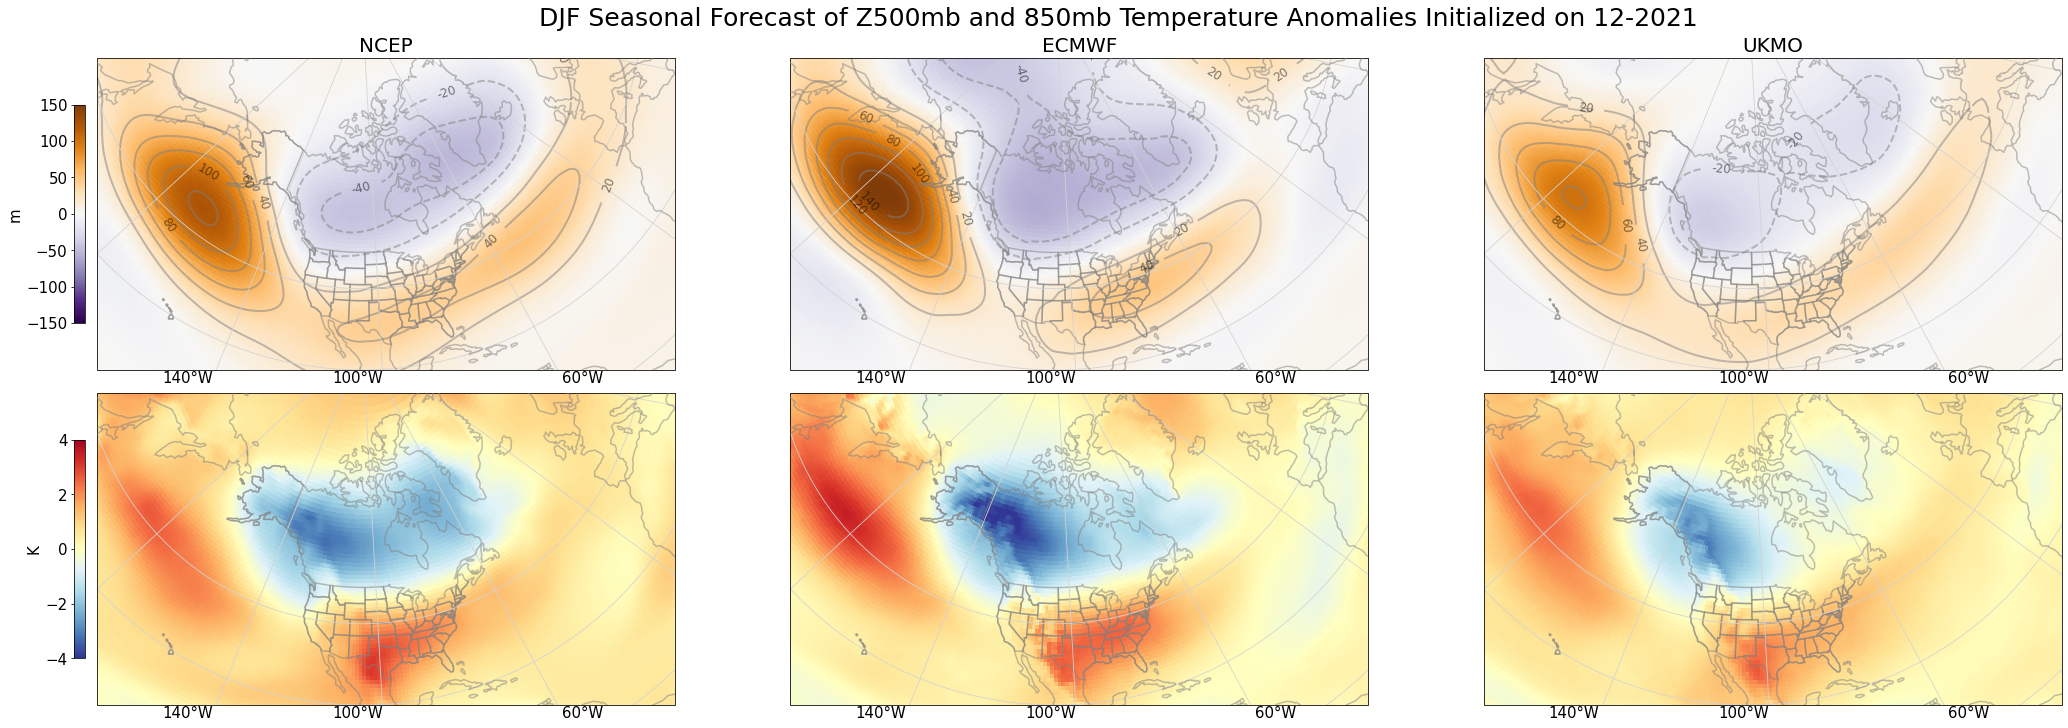

In [165]:
lccproj = ccrs.PlateCarree()                               # the local projection 
projection = ccrs.LambertConformal(central_longitude=255)  # the projection we want to see centered on the U.S. 

fig, axes = plt.subplots(nrows=nrows,ncols=ncols, subplot_kw={'projection': projection},figsize=fig_size, constrained_layout=True)   # set the subplots and their projection 

extent = [-180, -10, 20, 80]
labels = [x.upper() for x in model_dict.keys()]        # Why retype the model names? This capitalizes the model dictionary keys to use as labels. This isn't very formal so it works here.


for i,ax in enumerate(axes.flatten()):

        
        ## this allows for even and odd rows to be selected so that if more than 4 models are selected, 
        ## it automatically adjusts to have the pressure on even rows and temp on odd 
        
        ev_odd = i//slicer % 2
        
        if ev_odd == False:
        
            dx = 10      # dx for filled contour
            c_dx = 20    # dx for contour lines
            
            if i > 7:
                
                i -= slicer
                
            if i+1 > len(model_dict.keys()):
                ax.set_axis_off()
                
            else:
                
                ax = formatter(ax, extent)
                
                ax.set_title(labels[i], fontsize = 20)  # label only set for even rows as the odd rows plot the same model as above just different variable         

                zf = ax.pcolormesh(z500[i].longitude, z500[i].latitude, z500[i], transform = lccproj, cmap = 'PuOr_r', vmin = -150, vmax = 150)       # pcolormesh is significantly faster than contourf

                zc = ax.contour(z500[i].longitude, z500[i].latitude, z500[i], transform = lccproj,
                                  levels = np.concatenate([np.arange(-200,0,c_dx), np.arange(c_dx,200+c_dx,c_dx)]), colors = 'grey', linewidths = 2, alpha = 0.5)    #np.concatenate was used here to avoid having a '0' line  
                zc.clabel(fontsize=12, colors='k', inline=1, inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)     # Label those contours! 


        else:
            
            dx = 0.05  # dx for filled contour
            c_dx = 0.5 # dx for contour lines
            
            i -= slicer         # this ensures the correct item from the list is being grabbed 
            
            
            if i > 7:
                
                i -= slicer
                

            if i+1 > len(model_dict.keys()):        # 'turn off' the plot to correctly adjust for the number of models 
                
                ax.set_axis_off()
                
            else:
                
                ax = formatter(ax, extent)
            
                tf = ax.pcolormesh(temp[i].longitude, temp[i].latitude, temp[i], transform = lccproj, cmap = 'RdYlBu_r', vmin = -4, vmax = 4)      

                
# add the colorbars and edit some of their params 

cb1 = fig.colorbar(zf, ax=axes[0, :], shrink = 0.7, pad = 0.005, location = 'left') 
cb2 = fig.colorbar(tf, ax=axes[1, :], shrink = 0.7, pad = 0.005, location = 'left')  

cb1.ax.tick_params(labelsize=15)
cb2.ax.tick_params(labelsize=15)
cb1.set_label(label='m', size = 15)
cb2.set_label(label='K', size = 15)


if len(axes.flatten()) > 8:
    cb3 = fig.colorbar(zf, ax=axes[2, :], shrink = 0.7, pad = 0.005, location = 'left')  
    cb4 = fig.colorbar(tf, ax=axes[3, :], shrink = 0.7, pad = 0.005, location = 'left')  

    cb3.ax.tick_params(labelsize=15)
    cb4.ax.tick_params(labelsize=15)
    cb3.set_label(label='m', size = 15)
    cb4.set_label(label='K', size = 15)


fig.suptitle(f'{plot_string} Seasonal Forecast of Z500mb and 850mb Temperature Anomalies Initialized on {init_mon}-{init_year}', fontsize=25, x = 0.515);     # don't forget to label :D 
    

plt.savefig(f'Seasonal_forecast_z500_ta_{init_year}_{init_mon}.png', bbox_inches = "tight")     # bbox_inches limits the extra whitespcae once saved 
